In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from ood_common import (conv_classifier,
                        get_mnist_data, 
                        get_ood_data_random_uniform, 
                        get_ood_data_cifar10)

%matplotlib inline

In [196]:
def plot_hist_and_roc(is_id, scores):
    
    fpr, tpr, _ = roc_curve(is_id, scores)
    auc = roc_auc_score(is_id, scores)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    ax[0].hist(
        scores[is_id],
        label='in-distribution', bins=30,
        edgecolor='blue', linewidth=1, fill=None)
    ax[0].hist(
        scores[~is_id],
        label='out-of-distribution', bins=30,
        edgecolor='red', linewidth=1, fill=None)

    ax[0].set_xlabel('score')
    ax[0].set_ylabel('freq')
    ax[0].set_title('Score Histogram')
    ax[0].legend()
    
    ax[1].plot(fpr, tpr, 'b', label=f'AUC={auc:.4f}')
    ax[1].plot([0, 1], [0, 1], 'g--', label=f'baseline AUC=0.5')
    
    ax[1].set_xlabel('FPR')
    ax[1].set_ylabel('TPR')
    
    ax[1].set_title('ROC Curve')
    ax[1].legend()
    
    plt.show()

# Out-of-Distribution Detection

Replication of the experiments
from "A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks"
paper (https://arxiv.org/abs/1610.02136)

The main idea is that out-of-distribution samples have lower
max softmax probability than in-distribution samples.

I compared the results with entropy thresholding.
Softmax approach seems to work better.

## Single Model - Softmax Thresholding

In [62]:
X_train, X_test, y_train, y_test = get_mnist_data(fashion=True)
model = conv_classifier()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)              

In [63]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=4,
    validation_split=0.1,
    verbose=1)

model.evaluate(X_test, y_test, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/4
54000/54000 [==============================] - 15s 281us/sample - loss: 0.6920 - accuracy: 0.7514 - val_loss: 0.4333 - val_accuracy: 0.8497
Epoch 2/4
54000/54000 [==============================] - 15s 283us/sample - loss: 0.4467 - accuracy: 0.8395 - val_loss: 0.3791 - val_accuracy: 0.8638
Epoch 3/4
54000/54000 [==============================] - 15s 277us/sample - loss: 0.4028 - accuracy: 0.8560 - val_loss: 0.3515 - val_accuracy: 0.8737
Epoch 4/4
10000/10000 [==============================] - 1s 133us/sample - loss: 0.3573 - accuracy: 0.8734


[0.35729653549194335, 0.8734]

### Uniform Noise

In [93]:
n = 10000
ood_data_random_uniform = get_ood_data_random_uniform(n=n)
X_test_ood_u = np.concatenate((X_test, ood_data_random_uniform))
y_test_ood_u = np.concatenate((y_test.argmax(axis=1), -1 * np.ones(n)))

y_pred_max_proba_u = model.predict_proba(X_test_ood_u).max(axis=1)

In [ ]:
# napr chceme 0.1 fpr => vysledkem bude xx tpr pro dany roc

# Tady napsat neco jakoze tohle plati jen pro ood z "tohodle datasetu" pro produkcni ood data ktery
# jsou jiny ROC/thresholding muze bejt jinej

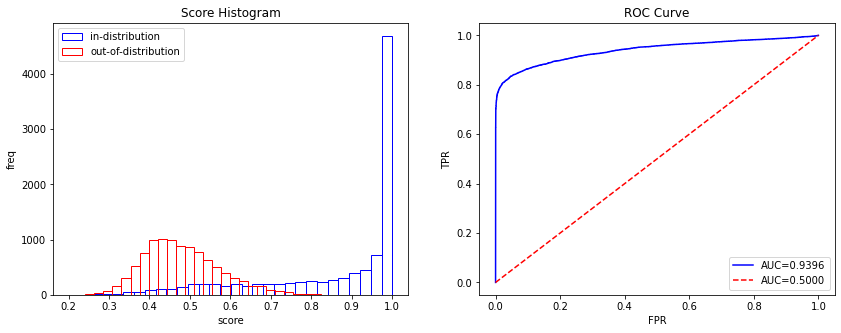

In [100]:
plot_hist_and_roc(y_test_ood_u != -1, y_pred_max_proba_u)

### CIFAR-10

In [95]:
ood_data_cifar10 = get_ood_data_cifar10()

X_test_ood_c = np.concatenate(
    (X_test, ood_data_cifar10))
y_test_ood_c = np.concatenate(
    (y_test.argmax(axis=1), -1 * np.ones(len(ood_data_cifar10))))

y_pred_max_proba_c = model.predict_proba(X_test_ood_c).max(axis=1)

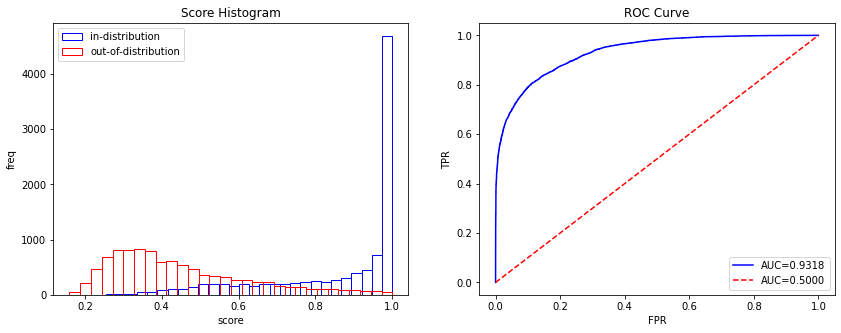

In [101]:
plot_hist_and_roc(y_test_ood_c != -1, y_pred_max_proba_c)

## Model Ensemble - Entropy Thresholding

In [29]:
from tensorflow.keras.losses import CategoricalCrossentropy

categorical_crossentropy = CategoricalCrossentropy()


def entropy(y):
    """
    https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    p_y = (pd.Series(y).value_counts() / len(y)).values
    return -np.sum(p_y * np.log2(p_y)) 


def test_entropy():
    y = ['A', 'A', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'D']
    
    assert entropy(y) == 1.8464393446710154


test_entropy()

In [176]:
class BaggingEnsemble:
    
    def __init__(self, model_factory=conv_classifier):
        self._model_factory = model_factory
        self._models = None
    
    @staticmethod
    def _sample_with_replacement(X, y):
        n = X.shape[0]
        idx = np.random.randint(0, n, size=n)
        return X[idx, :], y[idx]
    
    @classmethod
    def _create_bagging(cls, X, y, m):
        for _ in range(m):
            yield cls._sample_with_replacement(X, y)
    
    def _fit_models(self, bagging, epochs):
        for i, (X, y) in enumerate(bagging):            
            model = self._model_factory()
            hist = model.fit(X, y, batch_size=128, epochs=epochs, verbose=0)
            
            loss, acc = [hist.history[k][-1] for k in ('loss', 'accuracy')]
            print(f"Model={i} finished. Train loss={loss:.2f}, "
                  f"train acc={acc:.2f}.")

            yield model

    def fit(self, X, y, m=25, epochs=3):
        bagging = self._create_bagging(X, y, m)
        self._models = list(self._fit_models(bagging, epochs))
        
    def predict_classes(self, X):
        return np.hstack(
            [m.predict_classes(X)[:, np.newaxis] for m in self._models])
    
    def evaluate(self, X, y_true):
        
        def mode(x):
            return pd.Series(x).value_counts().index[0]
        
        y_pred_ensemble = self.predict_classes(X)
        y_pred = np.apply_along_axis(mode, 1, y_pred_ensemble)

        print(f'Accuracy={accuracy_score(y_true.argmax(axis=1), y_pred)}')


def test_sample_with_replacement():
    n = 10000
    X = np.array(range(n))[:, np.newaxis]
    y = np.array(range(n))
    
    X_, _ = BaggingEnsemble._sample_with_replacement(X, y)
    share = np.unique(X_).shape[0] / n
    assert round(share * 10) == 6


test_sample_with_replacement()

In [120]:
ensemble = BaggingEnsemble()
# ensemble._models = models
ensemble.fit(X_train, y_train)

Model=0 finished. Train loss=0.39, train acc=0.86.
Model=1 finished. Train loss=0.38, train acc=0.86.
Model=2 finished. Train loss=0.38, train acc=0.86.
Model=3 finished. Train loss=0.38, train acc=0.86.
Model=4 finished. Train loss=0.38, train acc=0.86.
Model=5 finished. Train loss=0.38, train acc=0.86.
Model=6 finished. Train loss=0.37, train acc=0.87.
Model=7 finished. Train loss=0.40, train acc=0.86.
Model=8 finished. Train loss=0.38, train acc=0.87.
Model=9 finished. Train loss=0.39, train acc=0.86.
Model=10 finished. Train loss=0.39, train acc=0.86.
Model=11 finished. Train loss=0.39, train acc=0.86.
Model=12 finished. Train loss=0.39, train acc=0.86.
Model=13 finished. Train loss=0.38, train acc=0.86.
Model=14 finished. Train loss=0.38, train acc=0.86.
Model=15 finished. Train loss=0.38, train acc=0.86.
Model=16 finished. Train loss=0.39, train acc=0.86.
Model=17 finished. Train loss=0.40, train acc=0.86.
Model=18 finished. Train loss=0.39, train acc=0.86.
Model=19 finished. Tra

In [121]:
ensemble.evaluate(X_test, y_test)

Accuracy=0.8769


### Uniform Noise

In [122]:
y_pred_entropy_u = np.apply_along_axis(entropy, 1, ensemble.predict_classes(X_test_ood_u))

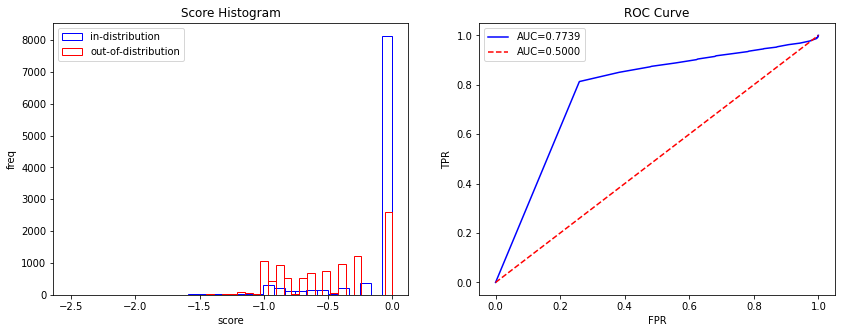

In [123]:
plot_hist_and_roc(y_test_ood_u != -1, -1 * y_pred_entropy_u)

### CIFAR-10

In [124]:
y_pred_entropy_c = np.apply_along_axis(entropy, 1, ensemble.predict_classes(X_test_ood_c))

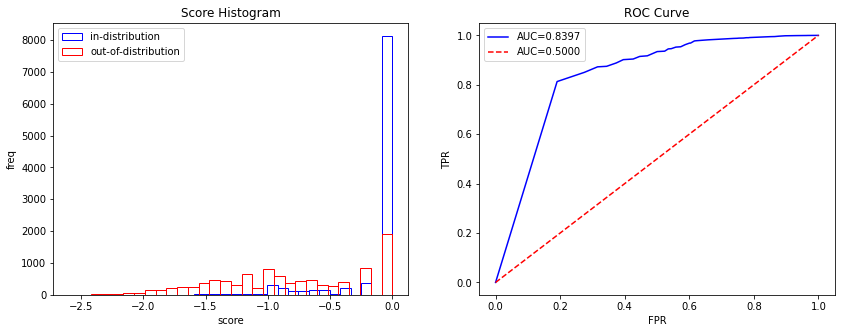

In [126]:
plot_hist_and_roc(y_test_ood_c != -1, -1 * y_pred_entropy_c)